# ДЗ 2. Проверка гипотез

Имя, Фамилия: Тань Сипэн

группа: 223

**Оценка(для проверяющего):** 0 из 32

**Дедлайн:** 24 ноября 23:59 (решение нужно сдать в энитаск)

# Введение. Несколько слов о шахматах

В этом домашнем задании вам будет представлен набор данных связанных с шахматами. Напомним, что шахматная партия может заканчиваться одним из трёх исходов:
- Победа белых (записывается как 1-0)
- Победа чёрных (записывается как 0-1)
- Ничейный исход (записывается как 1/2-1/2)

Также, в соревновательных шахматах есть временной контроль: партии делятся на несколько категорий, в зависимости от того, сколько времени оппонненты имеют на размышления:
- Блиц (до 10 минут на все ходы, возможно с добавлением времени после каждого хода)
- Рапид (от 10 до 30 минут на все ходы, возможно с добавлением времени после каждого хода)
- Классические или медленные шахматы (от 30 минут на все ходы, часто с добавлением времени после 40 и 60 ходов)

Для того чтобы как-то классифицировать силу игроков, была введена рейтинговая система ELO, на основании которой игрокам присуждается ранг (например международный мастер или гроссмейстер) и формируются турниры. Отметим что рейтинг ELO меняется, в зависимости от того, в каком формате временного контроля игрок участвует (т.е. у одного человека разный рейтинг для блица, рапида и классических шахмат). 

В этом датасете собраны основные данные об шахматных партиях, сыгранными за период с 1980 по 2021 года.
- Представлены партии всех трех форматов, формат партии указан в поле ``control``
- Исход партии представлен в поле ``result``
- Рейтинги оппонентов записаны в полях ``elo_white`` и ``elo_black`` для рейтинга играющих за белых и за черных соответственно.  
    - Поле ``elo_average`` содержит среднее значение ``elo_white`` и ``elo_black`` -- _усредненный рейтинг (оппонентов)_. 
    - Поле ``elo_difference`` содержит в себе значение ``elo_white - elo_black``. 
- Поле ``opening`` содержит одно из пяти значений ``'A', 'B', 'C', 'D', 'E'``, которое кодирует информацию о нескольких первых ходах в партии (см. задачу 3 для деталей). 
- В поле ``length`` записано число сделанных ходов в партии. Обратите внимание, что ход -- это движение одной фигуры со стороны белых **и** движение одной фигуры со стороны чёрных, т.е. за один ход и белые и черные совершают по действию.
- Поля ``date`` и ``site`` содержат информацию о том, в каком году была сыграна партия и место её проведения соответственно. 

## Обзор данных (2 балла)
В этой секции вам предлагается познакомиться с данными. Посмотрите на три разных формата временного контроля. Сравните как в каждом из них 
- Распределены исходы партий (победа белых/победа чёрных/ничья)
- Распределены усреднённые рейтинги оппонентов партий 
- Распределены длительности партий 

**Бонус (max 3 дополнительных балла)** При желании, можно также посмотреть другие вещи --- например как менялось количество партий по декадам или пятилеткам. Попробуйте обнаружить и _объяснить_ интересные и статистически значимые феномены.  

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.precision', 5)
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

#add your imports if necessary

In [4]:
games_df = pd.read_csv("games.csv")
games_df.head()

,result,control,elo_white,elo_black,elo_average,elo_difference,length,opening,date,site
0,1/2-1/2,slow,2380,2330,2355.0,50,25,C,1980,Prague
1,1/2-1/2,slow,2425,2545,2485.0,-120,104,E,1980,Prague
2,0-1,slow,2445,2410,2427.5,35,85,C,1980,Prague
3,0-1,slow,2435,2445,2440.0,-10,82,D,1980,Prague
4,1/2-1/2,slow,2410,2380,2395.0,30,16,A,1980,Prague


In [5]:
games_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5767540 entries, 0 to 5767539
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   result          object 
 1   control         object 
 2   elo_white       int64  
 3   elo_black       int64  
 4   elo_average     float64
 5   elo_difference  int64  
 6   length          int64  
 7   opening         object 
 8   date            int64  
 9   site            object 
dtypes: float64(1), int64(5), object(4)
memory usage: 440.0+ MB


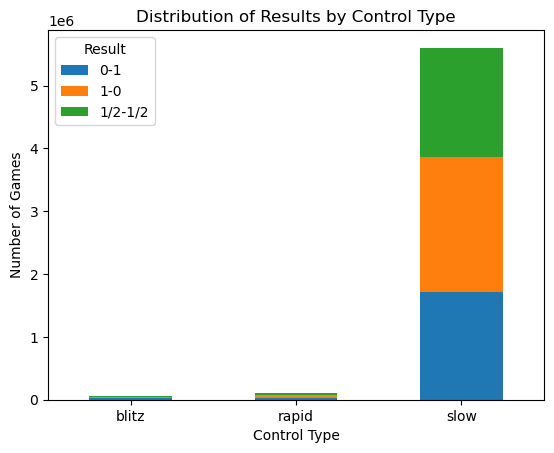

In [6]:
result_distribution = games_df.groupby(['control', 'result']).size().unstack(fill_value=0)

result_distribution.plot(kind='bar', stacked=True)
plt.title('Distribution of Results by Control Type')
plt.xlabel('Control Type')
plt.ylabel('Number of Games')
plt.xticks(rotation=0)
plt.legend(title='Result')
plt.show()

Видно, что в разных временных форматах совершенно разное распределение исходов партий. Это указывает нам на то что надо завести три различных набора данных и работать с каждым по отдельности:

In [8]:
slow  = games_df[games_df["control"] == "slow"]
rapid = games_df[games_df["control"] == "rapid"]
blitz = games_df[games_df["control"] == "blitz"]

Постройте для каждого из контролей распределение усредненного рейтинга партий и длин партий.

In [9]:
slow.head()

,result,control,elo_white,elo_black,elo_average,elo_difference,length,opening,date,site
0,1/2-1/2,slow,2380,2330,2355.0,50,25,C,1980,Prague
1,1/2-1/2,slow,2425,2545,2485.0,-120,104,E,1980,Prague
2,0-1,slow,2445,2410,2427.5,35,85,C,1980,Prague
3,0-1,slow,2435,2445,2440.0,-10,82,D,1980,Prague
4,1/2-1/2,slow,2410,2380,2395.0,30,16,A,1980,Prague


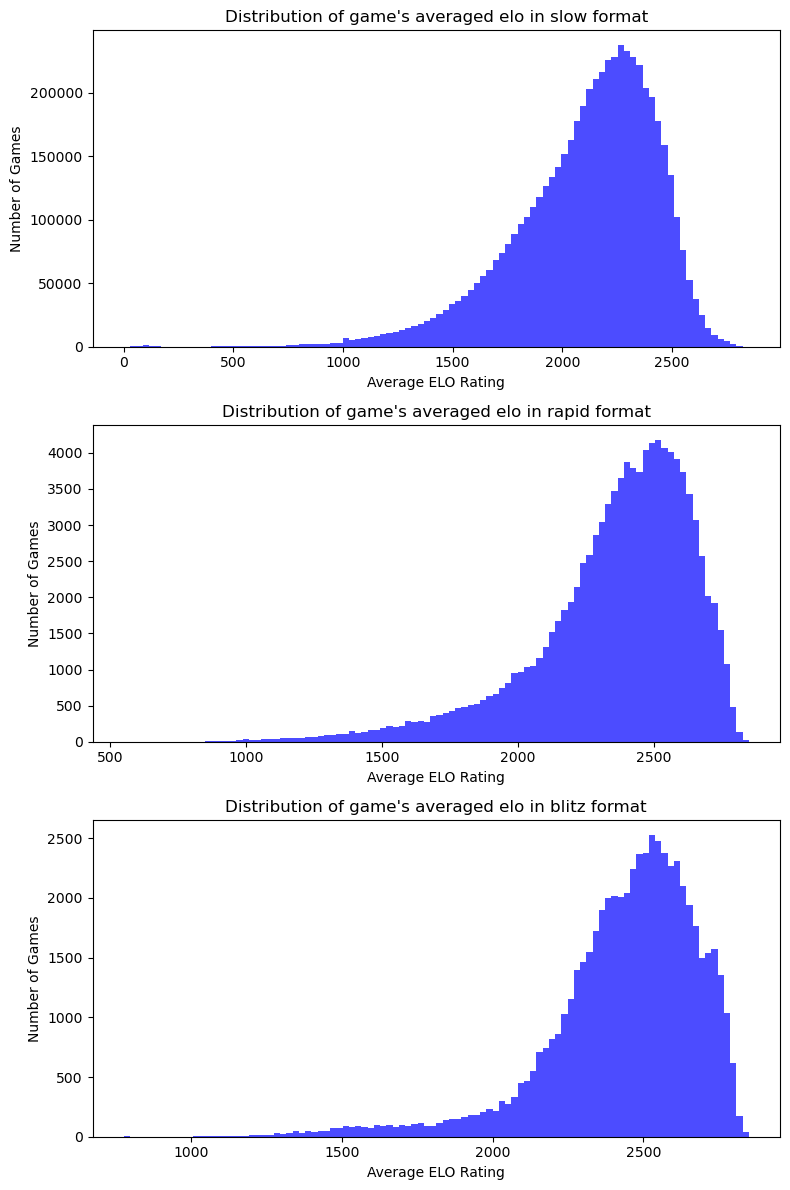

In [129]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

axs[0].set_title('Distribution of game\'s averaged elo in slow format')
axs[1].set_title('Distribution of game\'s averaged elo in rapid format')
axs[2].set_title('Distribution of game\'s averaged elo in blitz format')

axs[0].hist(slow['elo_average'], bins=100, color='blue', alpha=0.7)
axs[0].set_xlabel('Average ELO Rating')
axs[0].set_ylabel('Number of Games')

axs[1].hist(rapid['elo_average'], bins=100, color='blue', alpha=0.7)
axs[1].set_xlabel('Average ELO Rating')
axs[1].set_ylabel('Number of Games')

axs[2].hist(blitz['elo_average'], bins=100, color='blue', alpha=0.7)
axs[2].set_xlabel('Average ELO Rating')
axs[2].set_ylabel('Number of Games')

plt.tight_layout()
plt.show()

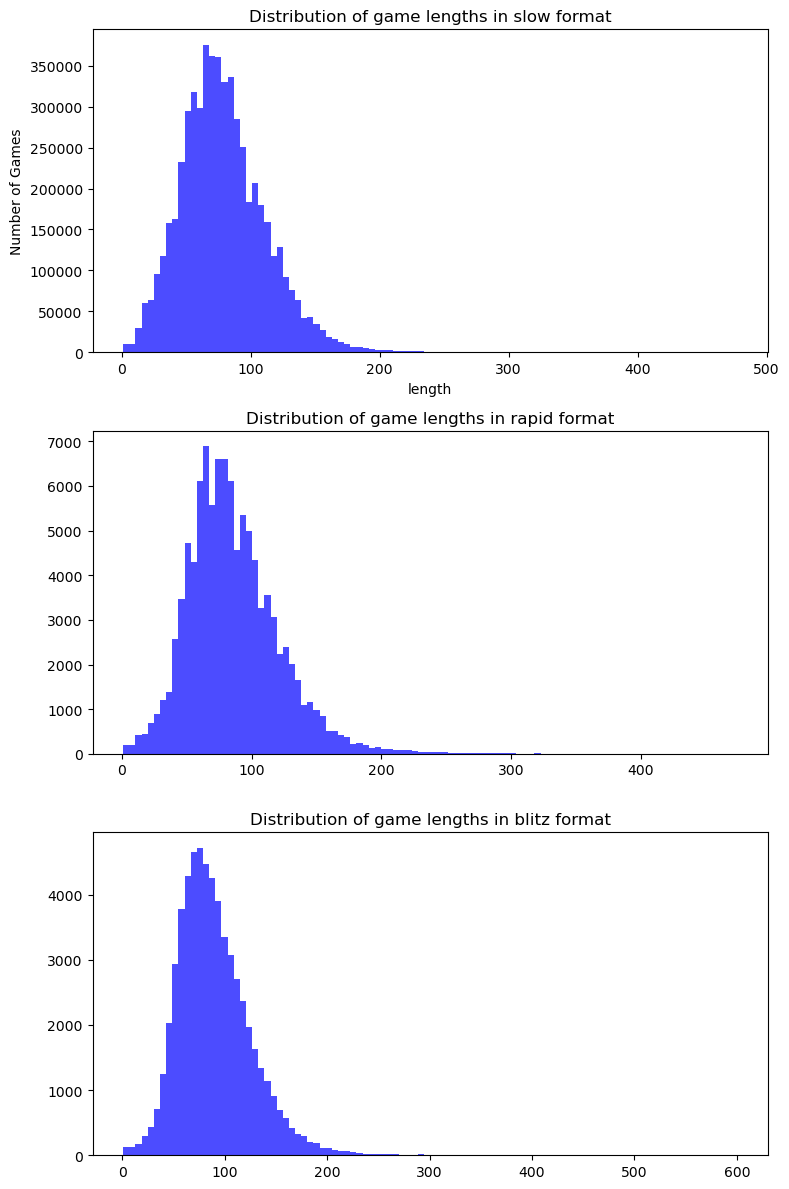

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

axs[0].set_title('Distribution of game lengths in slow format')
axs[1].set_title('Distribution of game lengths in rapid format')
axs[2].set_title('Distribution of game lengths in blitz format')

axs[0].hist(slow['length'], bins=100, color='blue', alpha=0.7)
axs[0].set_xlabel('length')
axs[0].set_ylabel('Number of Games')

axs[1].hist(rapid['length'], bins=100, color='blue', alpha=0.7)
axs[0].set_xlabel('length')
axs[0].set_ylabel('Number of Games')

axs[2].hist(blitz['length'], bins=100, color='blue', alpha=0.7)
axs[0].set_xlabel('length')
axs[0].set_ylabel('Number of Games')

plt.tight_layout()
plt.show()

# Задачи

## Разминка. Проверка гипотез о средних (5 баллов)

### Взгляд в прошлое. Рейтинг игр в Праге. (2 балла)
Пусть $X_1, \ldots, X_n \overset{\text{i.i.d}}{\sim} X$ --- выборка из некоторого распределения. Вспомните как строится асимптотический доверительный интервал для $\mathbb{E}[X]$, и, используя асимптотический z-test проверьте на уровне значимости $\alpha = 0.05$ гипотезу о том что математическое ожидание рейтинга партии равно 2389:
$$
    H_0 : \mathbb{E}[X] = 2389 \\
    H_1 : \mathbb{E}[X] \neq 2389
$$
для игр, сыгранных в Праге за период 1980-1989 г.

#### 1. Асимптотический доверительный интервал

Асимптотический доверительный интервал строится по формуле:
$$
\bar{X} \pm z_{\frac{\alpha}{2}} \cdot \frac{S}{\sqrt{n}}
$$
где:
  $$
  \bar{X} = \frac{1}{n} \sum_{i=1}^{n} X_i
  $$

  $$
  S = \sqrt{\frac{1}{n - 1} \sum_{i=1}^{n} (X_i - \bar{X})^2}
  $$

#### 2. Асимптотический z-тест

Для проверки гипотезы используется следующая статистика:
$$
z = \frac{\bar{X} - \mu_0}{\frac{S}{\sqrt{n}}}
= \frac{{\frac{1}{n} \sum_{i=1}^{n} X_i} - 2389}{\frac{\sqrt{\frac{1}{n - 1} \sum_{i=1}^{n} (X_i - \bar{X})^2}}{\sqrt{n}}}
$$


In [85]:
from numpy.typing import ArrayLike
from typing import Tuple, Optional, Literal

hypothesis_side = Literal["both", "left", "right"]


class StatTestResult:
    """
    Wrapper that carries information about performed statistical test. 
    
    Attributes
    ----------
    statistics : float
        value of the test's statistics.
    p_value : float
        obtained p-value for the test's statistics.
    significance : float
        significance level for the performed test
    critical_value : float
        critical value of the test's statistics for the given significance level 
    test_name : str
        name of the test
    null_name: str
        formulation of the null hypothesis
    alternative_name : str
        formulation of the alternative hypothesis
    verdict: 
        test's verdict
    """
    def __init__(self, statistics : float, p_value : float, significance : float, critical_value : float,\
                        test_name : str, null_name : str, alternative_name : str):
        self.statistics = statistics
        self.p_value = p_value
        self.significance = significance
        self.critical_value = critical_value
        self.name = test_name
        self.null = null_name
        self.alternative = alternative_name
        
        if self.p_value < self.significance:
            self.verdict = f"Reject H0 at significance level {significance}"
        else:
            self.verdict = f"Accept H0 at significance level {significance}"

    def __repr__(self):
        return f"""
        {self.name}. 
        H0: {self.null}
        H1: {self.alternative}
        ===================================
        Statistics value: {self.statistics}. Critical value: {self.critical_value}
        P-value: {self.p_value}, 
        Verdict: {self.verdict}
        """
    def __str__(self):
        return f"Statistics: {self.statistics}, P-value: {self.p_value}"

In [107]:
import numpy as np
from scipy.stats import norm

def z_test_one_sample(sample : ArrayLike, null_mean : float,
                      significance : float = 0.05, tail : hypothesis_side = 'both') -> StatTestResult:
    """
        Performs asymptotic z-test for the one sample
        
        Parameters
        ----------
        sample : ArrayLike
            sample on which z-test will be performed 
        null_mean : float
            value of mean under null hypothesis.
        significance : float
            significance level for the performed test
        tail : Literal["both", "left", "right"]
            alternative side
            
        Returns
        -------
        res : StatTestResult
            An object containing infomration about test results
    """
    sample_mean = np.mean(sample)
    sample_std = np.std(sample)
    n = sample.shape[0]
    z = np.sqrt(n) * (sample_mean - null_mean) / sample_std
    
    if tail == 'both':
        critical_value = norm.ppf(1 - significance / 2)
        p_value = 2 * (1 - norm.cdf(abs(z)))
    elif tail == 'right':
        critical_value = norm.ppf(1 - significance)
        p_value = 1 - norm.cdf(z)
    elif tail == 'left':
        critical_value = norm.ppf(significance)
        p_value = norm.cdf(z)
    
    return StatTestResult(
        statistics=z,
        p_value=p_value,
        significance=significance,
        critical_value=critical_value,
        test_name="One-sample z-test",
        null_name=f"Mean = {null_mean}",
        alternative_name=f"Mean != {null_mean}" if tail == 'both' else f"Mean {'>' if tail == 'right' else '<'} {null_mean}"
    )


In [108]:
games_df.head()

,result,control,elo_white,elo_black,elo_average,elo_difference,length,opening,date,site
0,1/2-1/2,slow,2380,2330,2355.0,50,25,C,1980,Prague
1,1/2-1/2,slow,2425,2545,2485.0,-120,104,E,1980,Prague
2,0-1,slow,2445,2410,2427.5,35,85,C,1980,Prague
3,0-1,slow,2435,2445,2440.0,-10,82,D,1980,Prague
4,1/2-1/2,slow,2410,2380,2395.0,30,16,A,1980,Prague


In [109]:
data = games_df['elo_average'][(1980 <= games_df['date']) & (games_df['date'] <= 1989) & (games_df['site'] == "Prague")]
z_test_one_sample(sample=data, null_mean=2389)


        One-sample z-test. 
        H0: Mean = 2389
        H1: Mean != 2389
        Statistics value: 0.05031134538441058. Critical value: 1.959963984540054
        P-value: 0.9598742829112306, 
        Verdict: Accept H0 at significance level 0.05
        

### Назад в будущее. Рейтинг игр в Москве. (3 балла)
После того как вы проверили эту гипотезу, проверьте гипотезу о том, что средний рейтинг классических партий проводимых в Москве в 2010-2019 годах выше, чем рейтинг в 2000-2009 годах. Вспомните как устроен z-тест для двух выборок и 

1. сформулируйте нулевую гипотезу и альтернативу;
2. укажите статистику и её распределение при верной нулевой гипотезе;
3. реализуйте тест и проверьте гипотезу на уровне значимости 0.05;

$$ z = \frac{(\bar{x} - \bar{y}) - \Delta_0}{\sqrt{\frac{\sigma_x^2}{n_x} + \frac{\sigma_y^2}{n_y}}} $$

In [119]:
def z_test_two_sample(sample_x : ArrayLike, sample_y : ArrayLike, null_mean_diff : float = 0,
                      significance : float = 0.05, tail : hypothesis_side = 'right') -> StatTestResult:
    """
        Performs asymptotic z-test for the two samples
        
        Parameters
        ----------
        sample_x : ArrayLike
            first sample for the z-test 
        sample_y : ArrayLike
            second sample for the z-test
        null_mean_diff : float
            differences of means under null hypothesis.
        significance : float
            significance level for the performed test
        tail : Literal["both", "left", "right"]
            alternative side
            
        Returns
        -------
        res : StatTestResult
            An object containing infomration about test results
    """
    
    n = len(sample_x)
    m = len(sample_y)
    
    mean_x = np.mean(sample_x)
    mean_y = np.mean(sample_y)
    
    std_x = np.std(sample_x) ** 2
    std_y = np.std(sample_y) ** 2
    
    sigma = np.sqrt(std_x / n + std_y / m)
    
    z = (mean_x - mean_y) / sigma
    
    if tail == 'both':
        critical_value = norm.ppf(1 - significance / 2)
        p_value = 2 * (1 - norm.cdf(abs(z)))
    elif tail == 'right':
        critical_value = norm.ppf(1 - significance)
        p_value = 1 - norm.cdf(z)
    elif tail == 'left':
        critical_value = norm.ppf(significance)
        p_value = norm.cdf(z)
    
    return StatTestResult(
        statistics=z,
        p_value=p_value,
        significance=significance,
        critical_value=critical_value,
        test_name="Two-sample z-test",
        null_name=f"Mean difference = {null_mean_diff}",
        alternative_name=f"Mean difference {'>' if tail == 'right' else '<'} {null_mean_diff}"
    )

In [368]:
data_x = slow['elo_average'][(2010 <= slow['date']) & (slow['date'] <= 2019) & (slow['site'] == "Moscow")]
data_y = slow['elo_average'][(2000 <= slow['date']) & (slow['date'] <= 2009) & (slow['site'] == "Moscow")]
z_test_two_sample(data_x, data_y)


        Two-sample z-test. 
        H0: Mean difference = 0
        H1: Mean difference > 0
        Statistics value: -16.457647025505345. Critical value: 1.644853626951472
        P-value: 1.0, 
        Verdict: Accept H0 at significance level 0.05
        

In [120]:
data_x = games_df['elo_average'][(2010 <= games_df['date']) & (games_df['date'] <= 2019) & (games_df['site'] == "Moscow")]
data_y = games_df['elo_average'][(2000 <= games_df['date']) & (games_df['date'] <= 2009) & (games_df['site'] == "Moscow")]
z_test_two_sample(data_x, data_y)


        Two-sample z-test. 
        H0: Mean difference = 0
        H1: Mean difference > 0
        Statistics value: -5.563253602262303. Critical value: 1.644853626951472
        P-value: 0.9999999867604678, 
        Verdict: Accept H0 at significance level 0.05
        

## Задача 1. Инфляция рейтинга (5 баллов)

В течение времени правила подсчета рейтинга менялись. Для сравнения возьмем партии в классическом временном контроле и их рейтинги за периоды 2000-2009 года и 2010-2019 год. Нарисуйте гистограммы, которые описывают распределение усредненных рейтингов оппонентов в партиях за эти периоды.

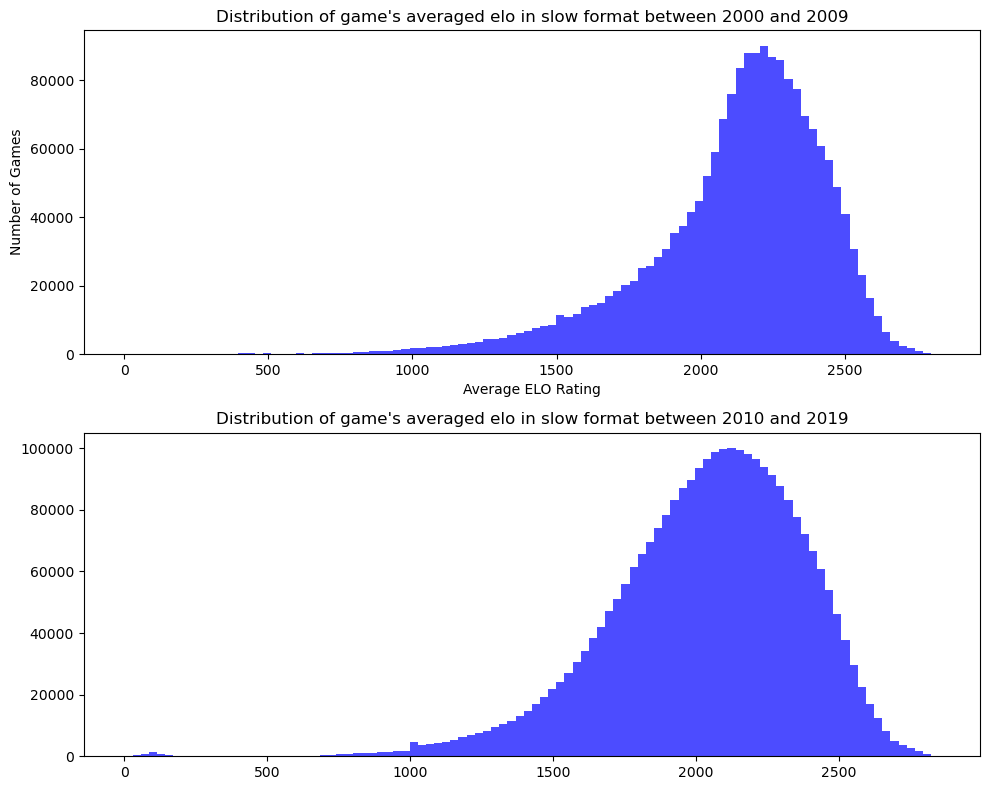

In [122]:
fig, axs = plt.subplots(2, 1, figsize = (10, 8))

axs[0].set_title('Distribution of game\'s averaged elo in slow format between 2000 and 2009')
axs[1].set_title('Distribution of game\'s averaged elo in slow format between 2010 and 2019')

axs[0].hist(slow['elo_average'][(2000 <= games_df['date']) & (games_df['date'] <= 2009)], bins=100, color='blue', alpha=0.7)
axs[0].set_xlabel('Average ELO Rating')
axs[0].set_ylabel('Number of Games')

axs[1].hist(slow['elo_average'][(2010 <= games_df['date']) & (games_df['date'] <= 2019)], bins=100, color='blue', alpha=0.7)
axs[0].set_xlabel('Average ELO Rating')
axs[0].set_ylabel('Number of Games')

plt.tight_layout()
plt.show()

Распространено мнение, что в силу изменений правил подсчета, высокий рейтинг стало получить легче --- произошла инфляция рейтинга. Проверьте, так ли это на самом деле, с помощью рангового критерия [Уилкоксона-Манна-Уитни](http://www.machinelearning.ru/wiki/index.php?title=Критерий_Уилкоксона-Манна-Уитни). В качестве распределения статистики можете брать подходящую аппроксимацию нормальным распределением с поправкой на повторяющиеся значения. Как и ранее,
1. сформулируйте нулевую гипотезу и альтернативу; объясните смысл математической формулировки нулевой гипотезы;
2. укажите статистику и её распределение при верной нулевой гипотезе;
3. реализуйте тест и проверьте гипотезу на уровне значимости 0.05;


$ U_X = R_X - \frac{n_X(n_X + 1)}{2}$

$ \mu_U = \frac{n_X \cdot n_Y}{2}$

$ \sigma_U = \sqrt{\frac{n_X \cdot n_Y \cdot (n_X + n_Y + 1)}{12}} $

$$\Longrightarrow Z = \frac{U_X - \mu_U}{\sigma_U} $$


In [127]:
from scipy.stats import rankdata # this can help. See docs.

def mwu_test(sample_x : ArrayLike, sample_y : ArrayLike, significance : float = 0.05, tail : hypothesis_side = 'right') -> StatTestResult:
    """        
        Performs Mann–Whitney U-test with correct support for ties in the data. 
        REMARK: Test uses normal approximation for the distribution of test statistics
                under null hypothesis.
    
        Parameters
        ----------
        sample_x : ArrayLike
            first sample for the U-test 
        sample_y : ArrayLike
            second sample for the U-test
        significance : float
            significance level for the performed test
        tail : Literal["both", "left", "right"]
            alternative side
            
        Returns
        -------
        res : StatTestResult
            An object containing infomration about test results
    """
    
    n_x = len(sample_x)
    n_y = len(sample_y)
    
    combined = np.concatenate([sample_x, sample_y])
    ranks = rankdata(combined)
    
    rank_x = ranks[:n_x]
    U_x = np.sum(rank_x) - n_x * (n_x + 1) / 2
    
    U_mean = n_x * n_y / 2
    U_std = np.sqrt(n_x * n_y * (n_x + n_y + 1) / 12)
    
    z = (U_x - U_mean) / U_std
    
    if tail == 'both':
        critical_value = norm.ppf(1 - significance / 2)
        p_value = 2 * (1 - norm.cdf(abs(z)))
    elif tail == 'right':
        critical_value = norm.ppf(1 - significance)
        p_value = 1 - norm.cdf(z)
    elif tail == 'left':
        critical_value = norm.ppf(significance)
        p_value = norm.cdf(z)
    
    return StatTestResult(
        statistics=z,
        p_value=p_value,
        significance=significance,
        critical_value=critical_value,
        test_name="Mann-Whitney U-test",
        null_name="не произошла инфляция рейтинга",
        alternative_name="произошла инфляция рейтинга"
    )
    

In [128]:
data_x = games_df['elo_average'][(2010 <= games_df['date']) & (games_df['date'] <= 2019)]
data_y = games_df['elo_average'][(2000 <= games_df['date']) & (games_df['date'] <= 2009)]
mwu_test(data_x, data_y)


        Mann-Whitney U-test. 
        H0: не произошла инфляция рейтинга
        H1: произошла инфляция рейтинга
        Statistics value: -286.6155478079176. Critical value: 1.644853626951472
        P-value: 1.0, 
        Verdict: Accept H0 at significance level 0.05
        

## Задача 2. Рейтинги и исход партий (7.5 баллов)

Исследуйте как, в зависимости от рейтинга участников, меняется распределение исхода партии. Мы предлагаем вам изучить как
- Разница в рейтинге влияет на шансы на результативный исход (победа одной из сторон)
- С ростом среднего рейтинга участников меняются шансы на победу

### Разрыв рейтинга и шансы на победу (5 баллов)

Нарисуйте гистограммы, показывающее как устроены исходы партий в зависимости от разницы в рейтинге для партий в разных формах временного контролля. 

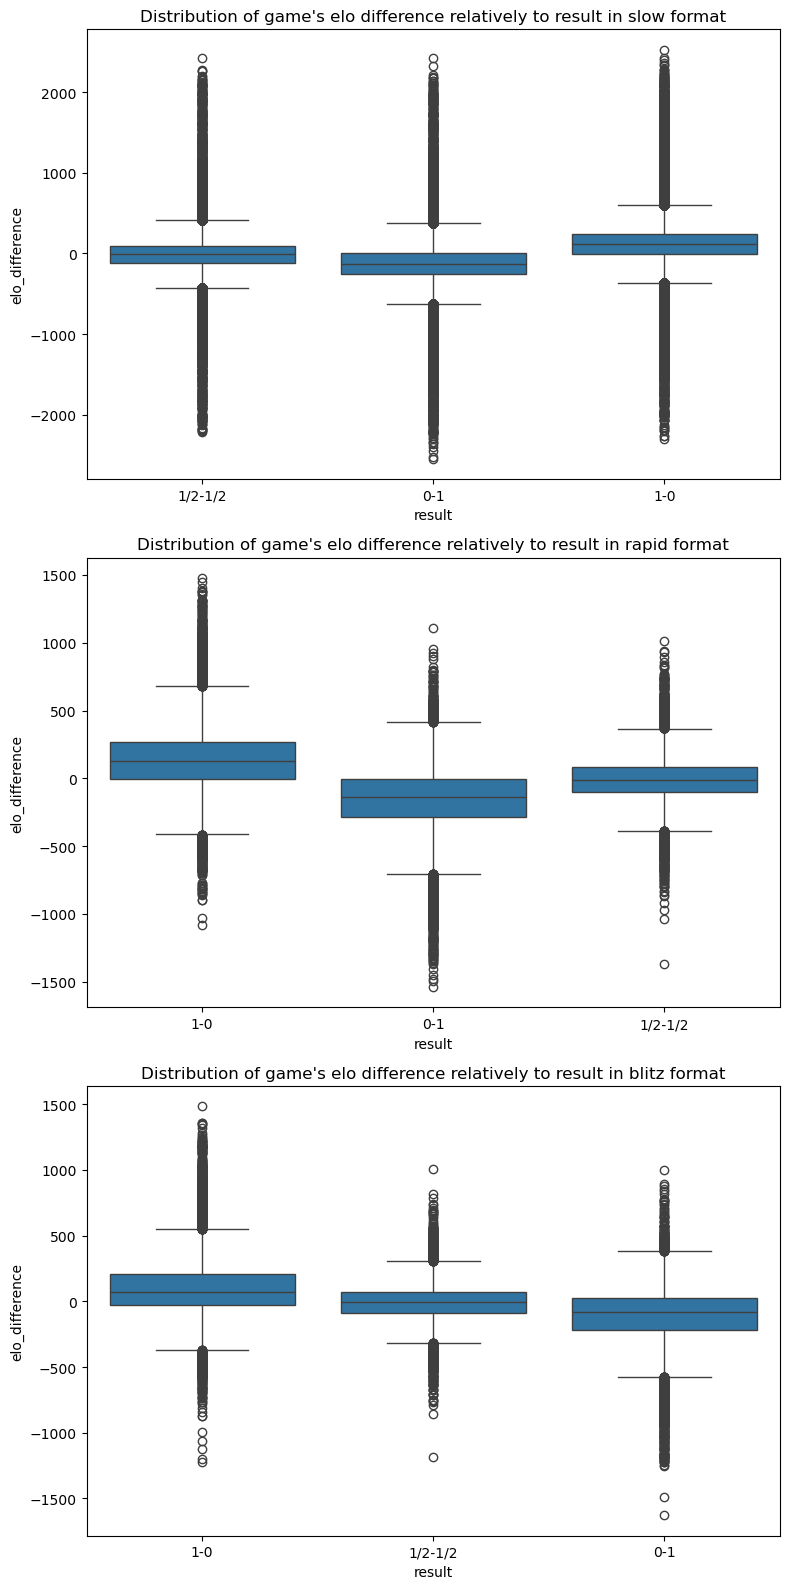

In [190]:
fig, axs = plt.subplots(3, 1, figsize=(8, 16))

axs[0].set_title('Distribution of game\'s elo difference relatively to result in slow format')
axs[1].set_title('Distribution of game\'s elo difference relatively to result in rapid format')
axs[2].set_title('Distribution of game\'s elo difference relatively to result in blitz format')

sns.boxplot(x='result', y='elo_difference', data=slow, ax=axs[0])
axs[0].set_xlabel('result')
axs[0].set_ylabel('elo_difference')

sns.boxplot(x='result', y='elo_difference', data=rapid, ax=axs[1])
axs[1].set_xlabel('result')
axs[1].set_ylabel('elo_difference')

sns.boxplot(x='result', y='elo_difference', data=blitz, ax=axs[2])
axs[2].set_xlabel('result')
axs[2].set_ylabel('elo_difference')

plt.tight_layout()
plt.show()

Проверьте гипотезу "симметрии":
> Правда ли что шансы победы белых при разрыве рейтинга между участниками в $X$ пунктов такие же, как шансы на победу чёрных при разрыве рейтинга в $-X$ пунктов?

Для проверки такой гипотезы будем использовать критерий $\chi^2$ для проверки независимости факторов. 
- Подумайте, как должна выглядеть факторная таблица в этом случае?
- Сформулируйте как интерпретировать нулевую гипотезу критерия $\chi^2$ в контексте проверяемой нами гипотезы.
- Реализуйте проверку гипотезы. 

Строим факторную таблицу

| Разница  | Победа белых 1-0 | Победа чёрных 0-1 | Ничейный исход 1/2-1/2|
|----------|--------|--------|------|
| $X$      | 1-0      | 0-1      | 1/2-1/2    |
| $-X$     | 1-0      | 0-1      | 1/2-1/2    |

Формула для расчета ожидаемых частот:

$$ E_{ij} = \frac{(R_i \times C_j)}{N} $$

хи-квадрат:
$$ \chi^2 = \sum \frac{(O_{ij} - E_{ij})^2}{E_{ij}} $$

где $O$ — наблюдаемая частота, $E$ — ожидаемая частота.


In [391]:
from scipy.stats import chi2

def chi2_contingency(observed : ArrayLike, significance : float = 0.05) -> StatTestResult:
    """
        Performs chi-square independence test test for contingency table
        
        Parameters
        ----------
        observed : ArrayLike
            contingency tablefor the test 
        significance : float
            significance level for the performed test
            
        Returns
        -------
        res : StatTestResult
            An object containing infomration about test results
    """
    row_totals = observed.sum(axis=1)
    col_totals = observed.sum(axis=0)
    total = observed.sum()

    expected = np.outer(row_totals, col_totals) / total
    chi2_stat = ((observed - expected) ** 2 / expected).sum()
    dof = (observed.shape[0] - 1) * (observed.shape[1] - 1)

    p_value = 1 - chi2.cdf(chi2_stat, dof)

    critical_value = chi2.ppf(1 - significance, dof)

    return StatTestResult(
        statistics=chi2_stat,
        p_value=p_value,
        significance=significance,
        critical_value=critical_value,
        test_name="Chi2",
        null_name="F[X] = F[Y]",
        alternative_name="F[X] != F[Y]"
    )

Проверьте сформулированную выше гипотезу для ваших данных:

In [182]:
a = games_df[(games_df['result'] == "1-0") & (games_df['elo_difference'] >= 0)].shape[0]
b = games_df[(games_df['result'] == "0-1") & (games_df['elo_difference'] >= 0)].shape[0]
c = games_df[(games_df['result'] == "1/2-1/2") & (games_df['elo_difference'] >= 0)].shape[0]

d = games_df[(games_df['result'] == "1-0") & (games_df['elo_difference'] < 0)].shape[0]
e = games_df[(games_df['result'] == "0-1") & (games_df['elo_difference'] < 0)].shape[0]
f = games_df[(games_df['result'] == "1/2-1/2") & (games_df['elo_difference'] < 0)].shape[0]

In [183]:
chi2_contingency(np.array([[a, b, c], [d, e, f]]))


        Chi2. 
        H0: F[X] = F[Y]
        H1: F[X] != F[Y]
        Statistics value: 972545.8683239025. Critical value: 5.99146454710798
        P-value: 0.0, 
        Verdict: Reject H0 at significance level 0.05
        

### Средний рейтинг и распределение исходов (2.5 балла)
Существует распространеное мнение, что чем выше рейтинг участников партии, тем более вероятно, что итогом партии станет ничья. Постройте гистограммы показывающее как устроены исходы партий в зависимости от рейтинга партии (``elo_average``) для партий в разных формах временного контролля. 

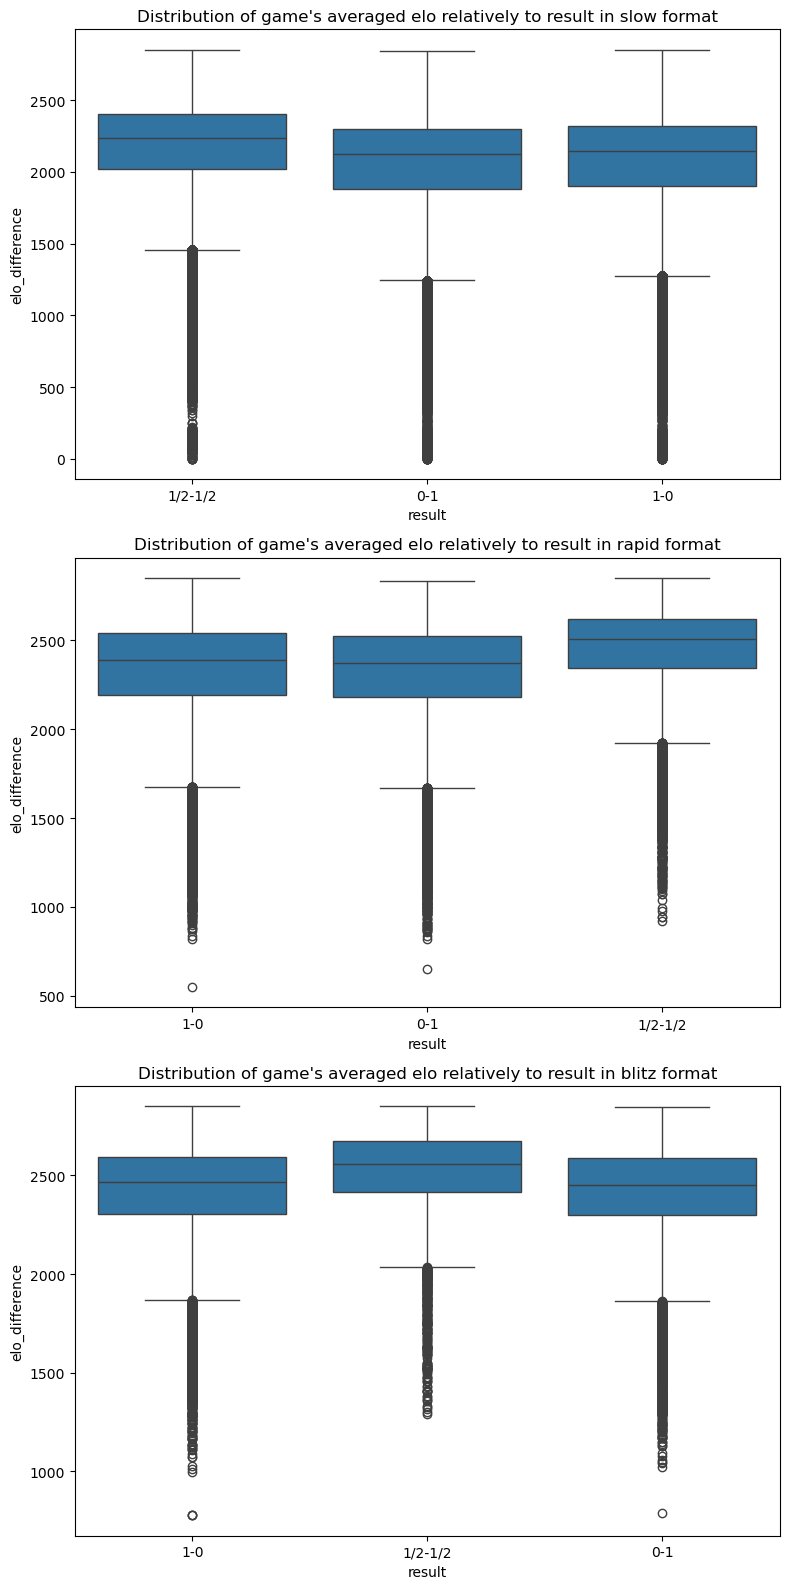

In [191]:
fig, axs = plt.subplots(3, 1, figsize=(8, 16))

axs[0].set_title('Distribution of game\'s averaged elo relatively to result in slow format')
axs[1].set_title('Distribution of game\'s averaged elo relatively to result in rapid format')
axs[2].set_title('Distribution of game\'s averaged elo relatively to result in blitz format')

sns.boxplot(x='result', y='elo_average', data=slow, ax=axs[0])
axs[0].set_xlabel('result')
axs[0].set_ylabel('elo_difference')

sns.boxplot(x='result', y='elo_average', data=rapid, ax=axs[1])
axs[1].set_xlabel('result')
axs[1].set_ylabel('elo_difference')

sns.boxplot(x='result', y='elo_average', data=blitz, ax=axs[2])
axs[2].set_xlabel('result')
axs[2].set_ylabel('elo_difference')

plt.tight_layout()
plt.show()

Согласно ChessBase, игроков можно условно делить на следующие категории, в зависимости от их рейтинга:
- 0-1000 Begginer
- 1000-1600 Average club player level
- 1600-2100 Strong club player level
- 2100-2300 International league player
- 2300-2450 International Master (IM) level
- 2450-2650 Grandmaster (GM) level
- \> 2650 Supergrandmaster, world champion level

Вместо игроков, мы будем брать усредненный рейтинг оппонентов в партии и применять классификацию выше. С помощью статистических методов, проверьте влияет ли класс партии на распределение исходов. Используйте уже знакомый вам тест $\chi^2$.
- Подумайте, как должна выглядеть факторная таблица в этом случае?
- Сформулируйте как интерпретировать нулевую гипотезу критерия $\chi^2$ в контексте проверяемой нами гипотезы.
- Реализуйте проверку гипотезы. 

Стоим таблицу:
| Класс партии          | 1-0 | 0-1 | 1/2-1/2 |
|-----------------------|--------|-------|-----------|
| Beginner              |        |       |           |
| Average club player   |        |       |           |
| Strong club player    |        |       |           |
| International league  |        |       |           |
| International Master  |        |       |           |
| Grandmaster           |        |       |           |
| Supergrandmaster      |        |       |           |

Остальные действии аналогично предыдущему номер

In [194]:
def classify_elo(elo):
    bins = [0, 1000, 1600, 2100, 2300, 2450, 2650, 3000]
    labels = ['Begginer', 'Average', 'Strong', 'International', 'IM', 'GM', 'SuperGM']
    for i in range(1, len(bins)):
        if bins[i - 1] <= elo and elo <= bins[i]:
            return labels[i - 1]

        
slow['category'] = slow['elo_average'].apply(classify_elo)
rapid['category'] = rapid['elo_average'].apply(classify_elo)
blitz['category'] = blitz['elo_average'].apply(classify_elo)
games_df['category'] = games_df['elo_average'].apply(classify_elo)
games_df.head()

,result,control,elo_white,elo_black,elo_average,elo_difference,length,opening,date,site,category
0,1/2-1/2,slow,2380,2330,2355.0,50,25,C,1980,Prague,IM
1,1/2-1/2,slow,2425,2545,2485.0,-120,104,E,1980,Prague,GM
2,0-1,slow,2445,2410,2427.5,35,85,C,1980,Prague,IM
3,0-1,slow,2435,2445,2440.0,-10,82,D,1980,Prague,IM
4,1/2-1/2,slow,2410,2380,2395.0,30,16,A,1980,Prague,IM


In [198]:
abels = ['Begginer', 'Average', 'Strong', 'International', 'IM', 'GM', 'SuperGM']
table_blitz = []
for level in abels:
    cur = []
    for res in ["1-0", "0-1", "1/2-1/2"]:
        cur.append(blitz[(blitz['result'] == res) & (blitz['category'] == level)].shape[0])
    table_blitz.append(cur)
table_blitz

[[4, 1, 0],
 [478, 469, 53],
 [1908, 1752, 309],
 [4054, 3518, 949],
 [5942, 5404, 2009],
 [9679, 8133, 4594],
 [4136, 3295, 3360]]

In [199]:
table_slow  = ...

abels = ['Begginer', 'Average', 'Strong', 'International', 'IM', 'GM', 'SuperGM']
table_rapid = []
for level in abels:
    cur = []
    for res in ["1-0", "0-1", "1/2-1/2"]:
        cur.append(rapid[(rapid['result'] == res) & (rapid['category'] == level)].shape[0])
    table_rapid.append(cur)
table_rapid

[[54, 46, 5],
 [1254, 1171, 332],
 [6181, 5332, 2069],
 [8073, 7065, 2998],
 [9746, 8451, 4967],
 [12724, 10196, 10922],
 [4000, 2798, 5072]]

In [200]:
abels = ['Begginer', 'Average', 'Strong', 'International', 'IM', 'GM', 'SuperGM']
table_slow = []
for level in abels:
    cur = []
    for res in ["1-0", "0-1", "1/2-1/2"]:
        cur.append(slow[(slow['result'] == res) & (slow['category'] == level)].shape[0])
    table_slow.append(cur)
table_slow

[[12649, 11453, 3678],
 [168174, 149286, 73978],
 [773904, 653120, 492760],
 [596831, 480338, 468887],
 [394897, 299672, 396407],
 [185091, 123205, 282445],
 [9744, 5343, 22175]]

In [202]:
print('Testing ... for slow format')
chi2_contingency(np.array(table_slow))

Testing ... for slow format



        Chi2. 
        H0: F[X] = F[Y]
        H1: F[X] != F[Y]
        Statistics value: 168050.21602826324. Critical value: 21.02606981748307
        P-value: 0.0, 
        Verdict: Reject H0 at significance level 0.05
        

In [203]:
print('Testing ... for rapid format')
chi2_contingency(np.array(table_rapid))

Testing ... for rapid format



        Chi2. 
        H0: F[X] = F[Y]
        H1: F[X] != F[Y]
        Statistics value: 4760.244792622887. Critical value: 21.02606981748307
        P-value: 0.0, 
        Verdict: Reject H0 at significance level 0.05
        

In [204]:
print('Testing ... for blitz format')
chi2_contingency(np.array(table_blitz))

Testing ... for blitz format



        Chi2. 
        H0: F[X] = F[Y]
        H1: F[X] != F[Y]
        Statistics value: 2039.3300346973551. Critical value: 21.02606981748307
        P-value: 0.0, 
        Verdict: Reject H0 at significance level 0.05
        

Проблема в том что критерий $\chi^2$ позволяет нам проверять факторы на зависимость/независимость, но ничего не говорит о структуре этой зависимости. Реализуйте вычисление ранговой корреляции Спирмена и посчитайте её, чтобы оценить есть ли 
- Монотонная зависимость между *шансами на ничью* и *рангом партии*
- Монотонная зависимость между *разницей шансов на победу у белых и у чёрных* и *рангом партии*

Используйте для этого партии сыгранные в блиц-контроле и дайте интерпретацию полученным результатам. 

$R = rank(X), S = rank(Y)$

$$
\rho = \frac{ \sum_{i=1}^{n} (R_i - \overline{R})(S_i - \overline{S}) }{ \sqrt{ \sum_{i=1}^{n} (R_i - \overline{R})^2 \sum_{i=1}^{n} (S_i - \overline{S})^2 } }
$$


In [205]:
games_df.head()

,result,control,elo_white,elo_black,elo_average,elo_difference,length,opening,date,site,category
0,1/2-1/2,slow,2380,2330,2355.0,50,25,C,1980,Prague,IM
1,1/2-1/2,slow,2425,2545,2485.0,-120,104,E,1980,Prague,GM
2,0-1,slow,2445,2410,2427.5,35,85,C,1980,Prague,IM
3,0-1,slow,2435,2445,2440.0,-10,82,D,1980,Prague,IM
4,1/2-1/2,slow,2410,2380,2395.0,30,16,A,1980,Prague,IM


In [341]:
table_blitz_ = games_df[games_df['control'] == 'blitz'].copy(deep=True)

In [344]:
table_blitz_

,result,control,elo_white,elo_black,elo_average,elo_difference,length,opening,date,site,category,white_win_prob
80778,1-0,blitz,2605,2490,2547.5,115,69,B,1987,St del Esterol,GM,0.43198
80779,1-0,blitz,2490,2605,2547.5,-115,99,A,1987,St del Esterol,GM,0.43198
80780,1/2-1/2,blitz,2605,2490,2547.5,115,72,A,1987,St del Esterol,GM,0.43198
80781,0-1,blitz,2490,2605,2547.5,-115,88,A,1987,St del Esterol,GM,0.43198
80782,1-0,blitz,2605,2490,2547.5,115,69,B,1987,St del Esterol,GM,0.43198
...,...,...,...,...,...,...,...,...,...,...,...,...
5766540,0-1,blitz,2767,2757,2762.0,10,142,C,2020,Stavanger,SuperGM,0.38328
5766541,1-0,blitz,2828,2728,2778.0,100,97,B,2020,Stavanger,SuperGM,0.38328
5766542,0-1,blitz,2757,2828,2792.5,-71,60,A,2020,Stavanger,SuperGM,0.38328
5766543,0-1,blitz,2633,2767,2700.0,-134,68,C,2020,Stavanger,SuperGM,0.38328


In [345]:
for level in ['Begginer', 'Average', 'Strong', 'International', 'IM', 'GM', 'SuperGM']:
    white_kol_level = table_blitz_[(table_blitz_['result'] == "1-0") & (table_blitz_['category'] == level)].shape[0]
    white_kol = table_blitz_[table_blitz_['category'] == level].shape[0]
    table_blitz_.loc[table_blitz_['category'] == level, 'white_win_prob'] = white_kol_level / white_kol

In [346]:
for level in ['Begginer', 'Average', 'Strong', 'International', 'IM', 'GM', 'SuperGM']:
    black_kol_level = table_blitz_[(table_blitz_['result'] == "0-1") & (table_blitz_['category'] == level)].shape[0]
    black_kol = table_blitz_[table_blitz_['category'] == level].shape[0]
    table_blitz_.loc[table_blitz_['category'] == level, 'black_win_prob'] = black_kol_level / black_kol

In [347]:
for level in ['Begginer', 'Average', 'Strong', 'International', 'IM', 'GM', 'SuperGM']:
    drwa_kol_level = table_blitz_[(table_blitz_['result'] == "1/2-1/2") & (table_blitz_['category'] == level)].shape[0]
    drwa_kol = table_blitz_[table_blitz_['category'] == level].shape[0]
    table_blitz_.loc[table_blitz_['category'] == level, 'draw_prob'] = drwa_kol_level / drwa_kol

In [348]:
table_blitz_['dominance'] = table_blitz_['white_win_prob'] - table_blitz_['black_win_prob']

In [349]:
table_blitz_['category_score'] = 0
abels = ['Begginer', 'Average', 'Strong', 'International', 'IM', 'GM', 'SuperGM']
bins = [0, 1000, 1600, 2100, 2300, 2450, 2650, 3000]

for i in range(7):
    table_blitz_.loc[table_blitz_['category'] == abels[i], 'category_score'] = bins[i + 1]

In [350]:
table_blitz_.sample(5)

,result,control,elo_white,elo_black,elo_average,elo_difference,length,opening,date,site,category,white_win_prob,black_win_prob,draw_prob,dominance,category_score
4521086,0-1,blitz,2710,2747,2728.5,-37,68,A,2016,Huaian,SuperGM,0.38328,0.30535,0.31137,0.07794,3000
4707093,1-0,blitz,2463,2537,2500.0,-74,134,C,2016,Sochi,GM,0.43198,0.36298,0.20503,0.06900,2650
4521258,1-0,blitz,2458,2554,2506.0,-96,97,B,2016,Huaian,GM,0.43198,0.36298,0.20503,0.06900,2650
1319725,1/2-1/2,blitz,2168,2247,2207.5,-79,205,D,2003,Dos Hermanas,International,0.47577,0.41286,0.11137,0.06290,2300
4381565,1-0,blitz,2705,2497,2601.0,208,79,C,2015,Moscow,GM,0.43198,0.36298,0.20503,0.06900,2650


In [351]:
abels = ['Begginer', 'Average', 'Strong', 'International', 'IM', 'GM', 'SuperGM']
i = 1
for level in abels:
    print(i, table_blitz_['draw_prob'][table_blitz_['category'] == level].unique())
    i += 1

1 [0.]
2 [0.053]
3 [0.07785336]
4 [0.1113719]
5 [0.15043055]
6 [0.20503437]
7 [0.31137059]


In [352]:
table_blitz_['draw_prob'].unique()

array([0.20503437, 0.31137059, 0.15043055, 0.1113719 , 0.07785336,
       0.053     , 0.        ])

In [353]:
draw_rank_data = list(zip([6, 7, 5, 4, 3, 2, 1], table_blitz_['draw_prob'].unique()))
dominance_rank_data = list(zip([6, 7, 5, 4, 3, 2, 1], table_blitz_['dominance'].unique()))

In [358]:
table_blitz_['dominance'].unique()

array([0.06899938, 0.07793532, 0.04028454, 0.06290342, 0.03930461,
       0.009     , 0.6       ])

In [356]:
abels = ['Begginer', 'Average', 'Strong', 'International', 'IM', 'GM', 'SuperGM']
i = 1
for level in abels:
    print(i, table_blitz_['dominance'][table_blitz_['category'] == level].unique())
    i += 1

1 [0.6]
2 [0.009]
3 [0.03930461]
4 [0.06290342]
5 [0.04028454]
6 [0.06899938]
7 [0.07793532]


In [362]:
def spearman_calc(X, Y):
    R = rankdata(X)
    S = rankdata(Y)
    
    R_mean = np.mean(R)
    S_mean = np.mean(S)
    
    numerator = np.sum((R - R_mean) * (S - S_mean))
    
    denominator = np.sqrt(np.sum((R - R_mean) ** 2) * np.sum((S - S_mean) ** 2))
    
    spearman_rho = numerator / denominator
    
    return spearman_rho

def spearman_rank_correlation(observations : ArrayLike) -> float:
    """        
        Calculates spearmean's rank correlation coefficient for data in the format
            (1, X[1]), (2, X[2]), .... (n, X[n])
        i.e. for the paired rank data sorted by the first component. No ties assumed
        in the data X.
        
        Parameters
        ----------
        observed : ArrayLike
             array of values X[1], X[2], ... X[n], 
            
        Returns
        -------
        spearman : float 
            value of the spearman correlation for the given data
    """
    x = np.array(observations[0])
    y = np.array(observations[1])
    
    spearman = spearman_calc(x, y)
    return spearman

In [363]:
rho = spearman_rank_correlation(np.array(draw_rank_data).T)
print(f'Correlation between draw odds and game rank: {rho}')

Correlation between draw odds and game rank: 1.0


In [364]:
rho1 = spearman_rank_correlation(np.array(dominance_rank_data).T)
print(f'Correlation between white dominance over black and game rank: {rho1}')

Correlation between white dominance over black and game rank: 0.21428571428571427


## Задача 3. Статистика дебютов (2.5 балла)

Другим распространённым мнением является то что выбор дебюта на высоком уровне не влияет на результативность партии. Все дебюты, согласно энциклопедии шахматных дебютов (ECO) делятся на 5 категорий
- A: Фланговые варианты.
- B: Полуоткрыте варианты.
- C: Открытые варианты.
- D: Закрытые и полузакрытые варианты.
- E: Системы типа индийской защиты.

Так как у нас нет доступа к партиям ИИ, которые сейчас считаются эталоном точной игры, мы ограничимся данными по партиям уровня супергроссмейстеров. 
Используя статистические методы, проверьте:
- Есть ли разница в предпочтениях дебютов (с точки зрения приведенных выше категорий) между партиями уровня супергроссмейстеров и партиями уровня гроссмейстеров в классическом временном контроле? 
- Правда ли что выбор между открытым (C) и закрытым (D) началом не влияет на распределение исхода партии? Проверьте это для разных форм временного контроля. Используйте партии только уровня супергроссмейстеров.

Для проверки будем использовать критерий $\chi^2$ (снова). Для каждой гипотезы, которое вы собираетесь проверять:
- сделайте визуализацию соответствующих данных;
- сформулируйте нулевую и альтернативную гипотезу. Опишите как применить критерий $\chi^2$ для проверки этих гипотез;
- реализуйте проверку гипотезы и дайте интерпретацию результатам;

In [369]:
games_df.head()

,result,control,elo_white,elo_black,elo_average,elo_difference,length,opening,date,site,category
0,1/2-1/2,slow,2380,2330,2355.0,50,25,C,1980,Prague,IM
1,1/2-1/2,slow,2425,2545,2485.0,-120,104,E,1980,Prague,GM
2,0-1,slow,2445,2410,2427.5,35,85,C,1980,Prague,IM
3,0-1,slow,2435,2445,2440.0,-10,82,D,1980,Prague,IM
4,1/2-1/2,slow,2410,2380,2395.0,30,16,A,1980,Prague,IM


In [378]:
super_ = games_df[(games_df['category'] == "SuperGM") & (games_df['control'] == 'slow')]
gm_ = games_df[(games_df['category'] == "GM") & (games_df['control'] == 'slow')]
super_.head()

,result,control,elo_white,elo_black,elo_average,elo_difference,length,opening,date,site,category
1401,1/2-1/2,slow,2655,2725,2690.0,-70,33,E,1980,Skara,SuperGM
1402,1/2-1/2,slow,2705,2610,2657.5,95,67,D,1980,Skara,SuperGM
1439,1/2-1/2,slow,2725,2590,2657.5,135,97,B,1980,Skara,SuperGM
1558,1/2-1/2,slow,2590,2725,2657.5,-135,33,C,1980,Skara,SuperGM
1566,1/2-1/2,slow,2725,2615,2670.0,110,90,B,1980,Bad Kissingen,SuperGM


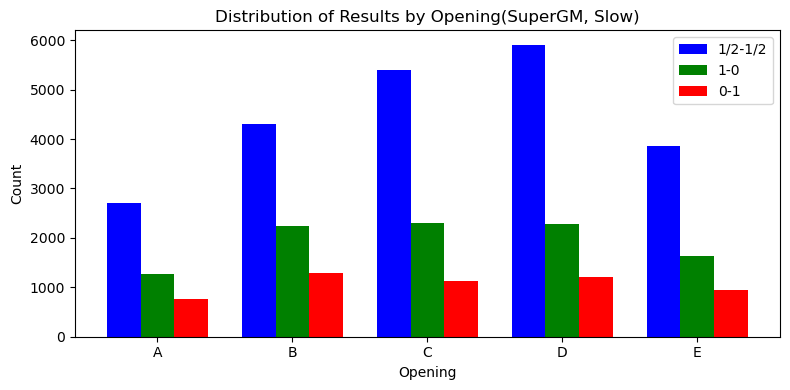

In [377]:
result_counts = super_.groupby(['opening', 'result']).size().unstack(fill_value=0)

openings = result_counts.index.tolist()

half_half = result_counts.get('1/2-1/2', 0).tolist()
one_zero = result_counts.get('1-0', 0).tolist()
zero_one = result_counts.get('0-1', 0).tolist()

bar_width = 0.25
index = np.arange(len(openings))

fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(index, half_half, bar_width, label="1/2-1/2", color='blue')
ax.bar(index + bar_width, one_zero, bar_width, label="1-0", color='green')
ax.bar(index + 2 * bar_width, zero_one, bar_width, label="0-1", color='red')

ax.set_xlabel('Opening')
ax.set_ylabel('Count')
ax.set_title('Distribution of Results by Opening(SuperGM, Slow)')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(openings)
ax.legend()

plt.tight_layout()
plt.show()

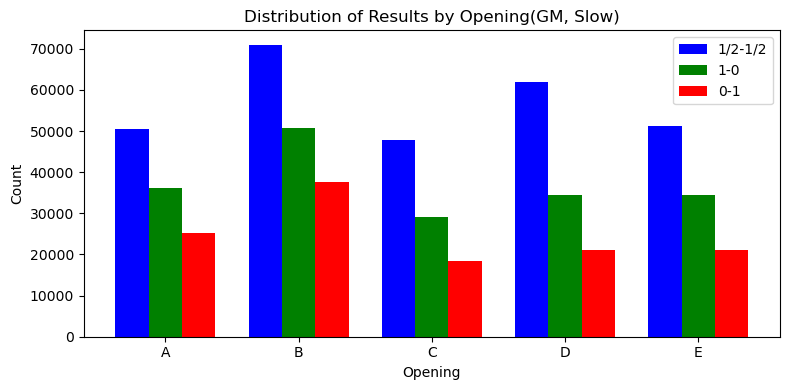

In [385]:
result_counts = gm_.groupby(['opening', 'result']).size().unstack(fill_value=0)

openings = result_counts.index.tolist()

half_half = result_counts.get('1/2-1/2', 0).tolist()
one_zero = result_counts.get('1-0', 0).tolist()
zero_one = result_counts.get('0-1', 0).tolist()

bar_width = 0.25
index = np.arange(len(openings))

fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(index, half_half, bar_width, label="1/2-1/2", color='blue')
ax.bar(index + bar_width, one_zero, bar_width, label="1-0", color='green')
ax.bar(index + 2 * bar_width, zero_one, bar_width, label="0-1", color='red')

ax.set_xlabel('Opening')
ax.set_ylabel('Count')
ax.set_title('Distribution of Results by Opening(GM, Slow)')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(openings)
ax.legend()

plt.tight_layout()
plt.show()

Стоим таблицу:
| Дебют          | A |  B | C | D | E |
|-----------------------|--------|-------|-----------| ----|----|
| SuperGM              |        |       |           | | |
| GM   |        |       |           | | |

Остальные действии аналогично предыдущему номер

In [380]:
vec = []
for level in ["GM", "SuperGM"]:
    cur = []
    for flag in ['A', 'B', 'C', 'D', 'E']:
        cur.append(games_df[(games_df['category'] == level) & (games_df['control'] == 'slow') & (games_df['opening'] == flag)].shape[0])
    vec.append(cur)
vec

[[112153, 159252, 95233, 117383, 106720], [4739, 7847, 8826, 9408, 6442]]

In [381]:
chi2_contingency(np.array(vec))


        Chi2. 
        H0: F[X] = F[Y]
        H1: F[X] != F[Y]
        Statistics value: 2922.5878011720106. Critical value: 9.487729036781154
        P-value: 0.0, 
        Verdict: Reject H0 at significance level 0.05
        

Теперь проверьте влияет ли выбор между открытым и закрытым началом:

Стоим таблицу:
| Дебют          | 0-1 |  1-0 | 1/2-1/2 |
|-----------------------|--------|-------|-----------|
| C             |        |       |           |
| D   |        |       |           |

Остальные действии аналогично предыдущему номер

In [396]:
vec_slow = []
for flag in ["C", "D"]:
    cur = []
    for res in ['0-1', '1-0', '1/2-1/2']:
        cur.append(games_df[(games_df['category'] == "SuperGM") & (games_df['control'] == 'slow') & (games_df['opening'] == flag) & (games_df['result'] == res)].shape[0])
    vec_slow.append(cur)
vec_slow

[[1119, 2310, 5397], [1216, 2287, 5905]]

### Slow

In [398]:
chi2_contingency(np.array(vec_slow))


        Chi2. 
        H0: F[X] = F[Y]
        H1: F[X] != F[Y]
        Statistics value: 8.41016888514769. Critical value: 5.99146454710798
        P-value: 0.01491952617268355, 
        Verdict: Reject H0 at significance level 0.05
        

### Rapid

In [399]:
vec_rapid = []
for flag in ["C", "D"]:
    cur = []
    for res in ['0-1', '1-0', '1/2-1/2']:
        cur.append(games_df[(games_df['category'] == "SuperGM") & (games_df['control'] == 'rapid') & (games_df['opening'] == flag) & (games_df['result'] == res)].shape[0])
    vec_rapid.append(cur)
vec_rapid

[[555, 870, 1179], [624, 835, 1259]]

In [400]:
chi2_contingency(np.array(vec_rapid))


        Chi2. 
        H0: F[X] = F[Y]
        H1: F[X] != F[Y]
        Statistics value: 4.942074049104526. Critical value: 5.99146454710798
        P-value: 0.08449718789243366, 
        Verdict: Accept H0 at significance level 0.05
        

### Blitz

In [401]:
vec_blitz = []
for flag in ["C", "D"]:
    cur = []
    for res in ['0-1', '1-0', '1/2-1/2']:
        cur.append(games_df[(games_df['category'] == "SuperGM") & (games_df['control'] == 'blitz') & (games_df['opening'] == flag) & (games_df['result'] == res)].shape[0])
    vec_blitz.append(cur)
vec_blitz

[[584, 724, 733], [658, 805, 748]]

In [402]:
chi2_contingency(np.array(vec_blitz))


        Chi2. 
        H0: F[X] = F[Y]
        H1: F[X] != F[Y]
        Statistics value: 2.058470934837385. Critical value: 5.99146454710798
        P-value: 0.3572800083859323, 
        Verdict: Accept H0 at significance level 0.05
        

Что изменится если брать уровень значимости 0.01? А если брать уровень значимости 0.1? Дайте ответы на эти вопросы и напишите интерпретацию полученных результатов.

#### Slow

In [403]:
chi2_contingency(np.array(vec_slow), significance=0.01)


        Chi2. 
        H0: F[X] = F[Y]
        H1: F[X] != F[Y]
        Statistics value: 8.41016888514769. Critical value: 9.21034037197618
        P-value: 0.01491952617268355, 
        Verdict: Accept H0 at significance level 0.01
        

In [404]:
chi2_contingency(np.array(vec_slow), significance=0.1)


        Chi2. 
        H0: F[X] = F[Y]
        H1: F[X] != F[Y]
        Statistics value: 8.41016888514769. Critical value: 4.605170185988092
        P-value: 0.01491952617268355, 
        Verdict: Reject H0 at significance level 0.1
        

#### Rapid

In [405]:
chi2_contingency(np.array(vec_rapid), significance=0.01)


        Chi2. 
        H0: F[X] = F[Y]
        H1: F[X] != F[Y]
        Statistics value: 4.942074049104526. Critical value: 9.21034037197618
        P-value: 0.08449718789243366, 
        Verdict: Accept H0 at significance level 0.01
        

In [406]:
chi2_contingency(np.array(vec_rapid), significance=0.1)


        Chi2. 
        H0: F[X] = F[Y]
        H1: F[X] != F[Y]
        Statistics value: 4.942074049104526. Critical value: 4.605170185988092
        P-value: 0.08449718789243366, 
        Verdict: Reject H0 at significance level 0.1
        

#### Blitz

In [407]:
chi2_contingency(np.array(vec_blitz), significance=0.01)


        Chi2. 
        H0: F[X] = F[Y]
        H1: F[X] != F[Y]
        Statistics value: 2.058470934837385. Critical value: 9.21034037197618
        P-value: 0.3572800083859323, 
        Verdict: Accept H0 at significance level 0.01
        

In [408]:
chi2_contingency(np.array(vec_blitz), significance=0.1)


        Chi2. 
        H0: F[X] = F[Y]
        H1: F[X] != F[Y]
        Statistics value: 2.058470934837385. Critical value: 4.605170185988092
        P-value: 0.3572800083859323, 
        Verdict: Accept H0 at significance level 0.1
        

**Заключение**: 

При более строгом уровне значимости 0.01 (низкая вероятность ошибки первого рода) мы часто не можем отклонить нулевую гипотезу, так как p-значение оказалось больше 0.01 в большинстве случаев.
При уровне значимости 0.1 (более высокая вероятность ошибки первого рода) мы видим больше случаев, где нулевая гипотеза отклоняется, так как p-значение оказалось меньше 0.1.

## Задача 4. Исследование длин партий в разных формах временного контроля (10 баллов)

Попробуйте разобраться в том, какому распределению следуют длительности партий в формате рапид. Выберете несколько распределений и попробуйте оценить их параметры. Постройте гистограммы на которых изображено распределение длительности партий и теоретические плотности распределений с оценёнными параметрами. 

Для оценки параметров распределений можно использовать метод ``fit()`` класса ``scipy.rv_continious()``.

In [411]:
rapid_ = games_df[games_df['control'] == 'rapid']
rapid_.head()

,result,control,elo_white,elo_black,elo_average,elo_difference,length,opening,date,site,category
1694,1-0,rapid,2390,2455,2422.5,-65,175,A,1980,Nijmegen,IM
1695,1-0,rapid,2545,2395,2470.0,150,47,E,1980,Nijmegen,GM
1696,1-0,rapid,2600,2410,2505.0,190,49,B,1980,Nijmegen,GM
1697,0-1,rapid,2465,2595,2530.0,-130,72,B,1980,Nijmegen,GM
1698,0-1,rapid,2395,2600,2497.5,-205,54,C,1980,Nijmegen,GM


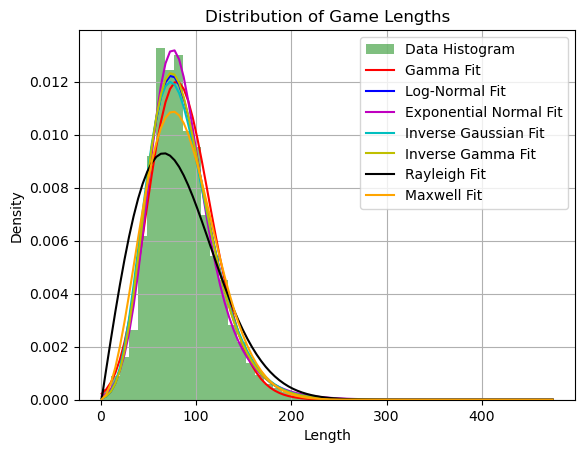

In [413]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma, lognorm, exponnorm, invgauss, invgamma, rayleigh, maxwell

lengths = rapid_['length'].values

params_gamma = gamma.fit(lengths)
params_lognorm = lognorm.fit(lengths)
params_exponnorm = exponnorm.fit(lengths)
params_invgauss = invgauss.fit(lengths)
params_invgamma = invgamma.fit(lengths)
params_rayleigh = rayleigh.fit(lengths)
params_maxwell = maxwell.fit(lengths)

plt.hist(lengths, bins=50, density=True, alpha=0.5, color='g', label='Data Histogram')

x = np.linspace(min(lengths), max(lengths), 100)

plt.plot(x, gamma.pdf(x, *params_gamma), 'r-', label='Gamma Fit')
plt.plot(x, lognorm.pdf(x, *params_lognorm), 'b-', label='Log-Normal Fit')
plt.plot(x, exponnorm.pdf(x, *params_exponnorm), 'm-', label='Exponential Normal Fit')
plt.plot(x, invgauss.pdf(x, *params_invgauss), 'c-', label='Inverse Gaussian Fit')
plt.plot(x, invgamma.pdf(x, *params_invgamma), 'y-', label='Inverse Gamma Fit')
plt.plot(x, rayleigh.pdf(x, *params_rayleigh), 'k-', label='Rayleigh Fit')
plt.plot(x, maxwell.pdf(x, *params_maxwell), 'orange', label='Maxwell Fit')

plt.title('Distribution of Game Lengths')
plt.xlabel('Length')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()

Выберите три наиболее на ваш взгляд подходящих распределения и постройте для них Q-Q график. Подробнее про Q-Q графики можно прочитать [здесь](https://habr.com/ru/articles/578754/) (обратите внимание, что в статье делается упор на Q-Q графики относительно нормального распределения --- вам же нужно построить графики относительно распределений, параметры которых вы оценили).

In [435]:
def qqplot(data : ArrayLike, distribution: stats.rv_continuous,  quantiles : int,  ax : plt.axis) -> plt.axis:
    """
        Plots Q-Q plot agains theoretical distribution. 
        
        Parameters
        ----------
        data : ArrayLike
            sample data
        distribution: stats.rv_continuous
            theoretical distribution agains which quantiles will be plotted
        quantiles: int
            number of quantiles (must be less than size of the data)
        ax: plt.axis
            PyPlot Axis object, on which QQ-plot should be plotted
            
        Returns
        -------
        ax: plt.axis 
            PyPlot Axis object with QQ-plot
    """
    
    sample_quantiles = np.percentile(data, np.linspace(0, 100, quantiles))
    
    params = distribution.fit(data)
    theoretical_quantiles = distribution.ppf(np.linspace(0, 1, quantiles), *params)

    ax.scatter(theoretical_quantiles, sample_quantiles, color='blue', label='Sample Quantiles')
    ax.plot([sample_quantiles.min(), 200], 
            [sample_quantiles.min(), 200], 
            color='red', linestyle='--', label='y=x')
    
    ax.set_title(f'Q-Q Plot against {distribution.name.capitalize()} Distribution')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles')
    ax.legend()
    ax.grid()

    return ax

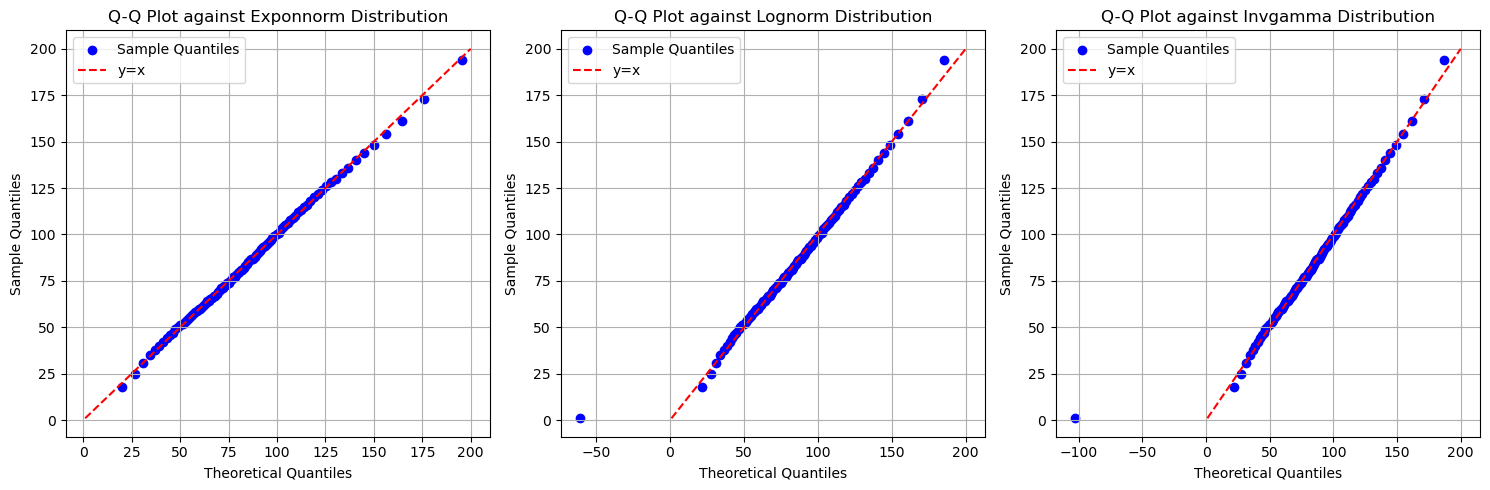

In [436]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

qqplot(lengths, stats.exponnorm, quantiles=100, ax=axs[0])
qqplot(lengths, stats.lognorm, quantiles=100, ax=axs[1])
qqplot(lengths, stats.invgamma, quantiles=100, ax=axs[2])

plt.tight_layout()
plt.show()

 На основе всего выше сделанного выберете одно распределение, которое вам кажется наиболее подходящим. После того как вы выбрали распределение $F_0$, проверьте соответствующую гипотезу согласия. Конкретнее, проверьте гипотезу
$$
H_0: X_1,..,X_n \sim F_0
$$
против альтернативы
$$
H_A: X_1,..,X_n \nsim F_0
$$


Такую гипотезу часто проверяют с помощью статистики критерия Колмогорова-Смирнова:
$$
D = \sqrt{n} \sup_x \vert F_{0} - \hat{F}(x)\vert,
$$
где $\hat{F}$ -- эмпирическая функция распределения, которая задётся как
$$
\hat{F}(x) = \frac{1}{n}\sum_{i=1}^n \mathbb{1}(X_i \leq x).
$$
Выражение $1(условие)$ равно $1$, если условие верно и $0$ в противном случае -- так выше считается количество элементов выборки $\leq x$. Статистика $D$ при больших $n$ (сотен уже достаточно) имеет распределение Колмогорова, так что можно построить критерий для проверки. Чтобы упростить техническую часть с подсчётом $D$, воспользуйтесь готовым тестом из пакета scipy.stats.

In [439]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

D, p_value = stats.kstest(lengths, 'exponnorm', args=(1, 0, np.exp(0)))

alpha = 0.05
print(f"Статистика D: {D}")
print(f"p-значение: {p_value}")

if p_value < alpha:
    print("Reject H0")
else:
    print("Accept H0")

Статистика D: 0.997032071377355
p-значение: 0.0
Reject H0


Объясните, почему получилось такое значение несмотря на то, что подобранное вами распределение достаточно неплохо описывает данные? Подумайте, можно ли как-то изменить процедуру проверки для того чтобы можно было воспользоваться этим тестом? Обратите внимание на две вещи:
1. Как считается статистка критерия КС и почему для наших данных эмпирическая функция распределения никогда не будет сходится к функции распределения выбранного вами распределения? Как можно сделать дискретные данные  не-дискретными?
2.  Обратите внимание на выброс в данных в районе где достигается значение статистики критерия (statistic location). С чем может быть связан этот выброс и как можно было бы его устранить?

Опишите и реализуйте измененную процедуру. 

Дискретная природа данных приводит к постоянной разнице между ЭФР и теоретической функцией распределения, что увеличивает значение статистики КС. И может быть еще наличие выбросов.

Теоретическая функция распределения непрерывна, из-за этого ЭФР никогда не будет полностью совпадать с теоретической функцией. Чтобы уменьшить эффект дискретности и приблизить данные к непрерывному виду, можно добавить к наблюдению небольшой случайный шум.

В области, где статистика КС достигает максимума, выбросы могут значительно влиять на результат теста, увеличивая значение статистики и уменьшая p-значение.

In [524]:
import copy
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

data = lengths.copy()
#np.random.seed(42)
noise = np.random.normal(0, np.sqrt(255), size=data.size)
data_continuous = data + noise

data_sorted = np.sort(data_continuous)
data_filtered = data_sorted[data_sorted < 400]

params_filtered = stats.exponnorm.fit(data_filtered)
D_filtered, p_value_filtered = stats.kstest(data_filtered, 'exponnorm', args=params_filtered)
print(f"Статистика D: {D_filtered}")
print(f"p-значение: {p_value_filtered}")

alpha = 0.05
if p_value_filtered < alpha:
    print("Reject H0")
else:
    print("Accept H0")


Статистика D: 0.0035845070329084128
p-значение: 0.13972809074107828
Accept H0


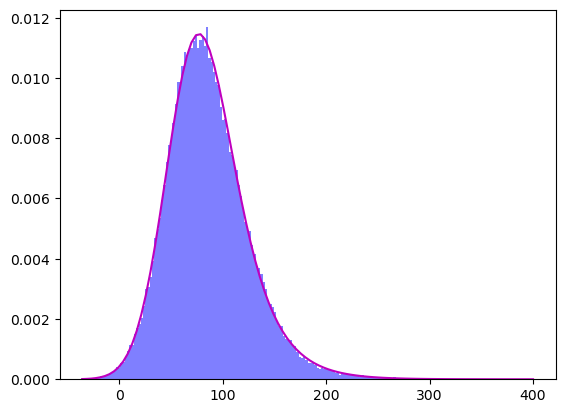

In [525]:
plt.hist(data_filtered, bins=200, density=True, alpha=0.5, color='b', label='Data Histogram')
x = np.linspace(min(data_filtered), max(data_filtered), 100)
plt.plot(x, exponnorm.pdf(x, *exponnorm.fit(data_filtered)), 'm-', label='Exponential Normal Fit')
plt.show()